In [1]:
!mkdir my_repo
!git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo

Cloning into 'my_repo'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 141 (delta 58), reused 116 (delta 33), pack-reused 0
Receiving objects: 100% (141/141), 2.89 MiB | 7.18 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [2]:
%cd my_repo

/content/my_repo


In [3]:
!pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 3.0 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb

from utils import util_data

kaggle.json not found, you cannot use kaggle module.


In [569]:
df = pd.read_csv("data/processed/gsm.csv")
df.head(3)

,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,network_technology,...,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
0,599.00,2019.0,6.3,1,0,0,0,1,1,4G,...,1,1,1440.0,3040.0,64.0,6.0,12.2,2.0,8.0,2.0
1,524.52,2019.0,5.7,1,0,0,0,1,1,4G,...,1,1,1080.0,2280.0,64.0,6.0,12.2,2.0,8.0,2.0
2,329.00,2019.0,6.0,1,0,0,1,1,1,4G,...,0,0,1080.0,2160.0,64.0,4.0,12.2,1.0,8.0,1.0


In [ ]:
#dup_cols = ["display_type", "display_size", "memory_card_slot", "sound_loudspeaker", "sound_3.5mm_jack", "comms_wlan", "misc_price", "comms_nfc", "px_width", "px_height", "gb_rom", "gb_ram"]
#all_cols = ["oem", "model", "display_type", "display_size", "memory_card_slot", "sound_loudspeaker", "sound_3.5mm_jack", "comms_wlan", "misc_price", "comms_nfc", "px_width", "px_height", "gb_rom", "gb_ram"]

# show duplicated rows
df[df.duplicated(keep=False)]

In [570]:
# Keep only the smartphones that are sold starting from 2015
df = df[df['launch_announced'] >= 2015].drop('launch_announced', axis=1)

df = df.dropna().drop_duplicates().reset_index(drop=True)

In [ ]:
# keep_cols = ["display_type", "display_size", "memory_card_slot", "sound_loudspeaker", "sound_3.5mm_jack", "comms_wlan", "misc_price", "comms_nfc", "px_width", "px_height", "gb_rom", "gb_ram"]

# df = df[keep_cols].dropna().drop_duplicates().reset_index(drop=True)

In [23]:
print(f"Null values:{df.isna().sum().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")

print(f"Number of rows: {df.shape[0]}")

Null values:0
Number of duplicated rows: 0
Number of rows: 1875


Binary categorization of Yes/No features

In [24]:
df.head()

,misc_price,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,network_technology,battery,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
0,599.00,6.30,1,0,0,0,1,1,4G,3700.0,1,1,1440.0,3040.0,64.0,6.0,12.2,2.0,8.0,2.0
1,524.52,5.70,1,0,0,0,1,1,4G,2800.0,1,1,1080.0,2280.0,64.0,6.0,12.2,2.0,8.0,2.0
2,329.00,6.00,1,0,0,1,1,1,4G,3700.0,0,0,1080.0,2160.0,64.0,4.0,12.2,1.0,8.0,1.0
3,304.00,5.60,1,0,0,1,1,1,4G,3000.0,0,0,1080.0,2220.0,64.0,4.0,12.2,1.0,8.0,1.0
4,110.00,5.71,0,1,0,1,0,0,4G,3020.0,0,0,720.0,1520.0,64.0,3.0,13.0,1.0,5.0,1.0


Standardization of numerical features

In [571]:
num_cols = ["display_size", "battery", "display_width", "display_height", "memory_rom_gb",
            "memory_ram_gb", "main_camera_resolution", "num_main_camera", "selfie_camera_resolution",
            "num_selfie_camera"]

scaler_num = {}
for col in num_cols:
    scaler_num[col] = StandardScaler()
    df[col] = scaler_num[col].fit_transform(df[col].values.reshape(-1, 1))

Price distribution

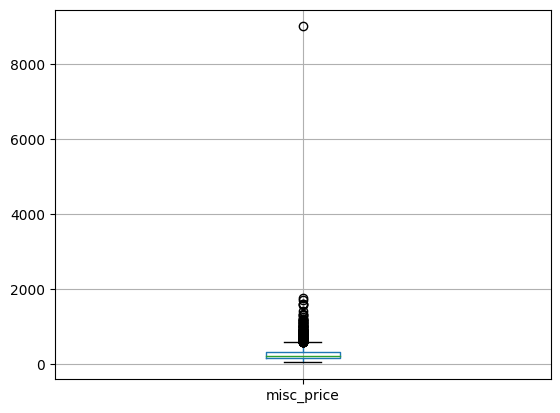

In [36]:
df.boxplot(column=["misc_price"])
plt.show()

Define bin ranges for the price

In [572]:
q1 = df.misc_price.quantile(0.25)
q3 = df.misc_price.quantile(0.75)
iqr = q3 - q1
# lower whiskers as 1.5 smaller than iqr
lower_bound = max(df.misc_price.min(), q1 - iqr * 1.5)
# upper whiskers as 1.5 greater than iqr
upper_bound = min(df.misc_price.max(), q3 + iqr * 1.5)

print(f"lower_bound: {lower_bound}, upper_bound: {upper_bound}")

lower_bound: 40.0, upper_bound: 575.0


In [573]:
df_iqr = df[df.misc_price.between(lower_bound, upper_bound, inclusive="both")]

print(f"Shape before: {df.shape}, shape after: {df_iqr.shape}")

Shape before: (1875, 20), shape after: (1741, 20)


In [574]:
# labels = ["low", "medium", "medium-high", "high", "very high"]
labels = ["low", "low-medium", "medium", "high"]
_, bins = pd.cut(df_iqr.misc_price, bins=len(labels), retbins=True, labels=labels)
# _, bins = pd.qcut(df_iqr.misc_price, q=len(labels), retbins=True, labels=labels)

print(f"Bins: {bins}")

Bins: [ 39.47 172.5  305.   437.5  570.  ]


In [575]:
bins[0] = df.misc_price.min()
bins[-1] = df.misc_price.max()
lab_cat = pd.Series(index=df.index, dtype="object")

for lab, (l, u) in enumerate(zip(bins[:-1], bins[1:])):
    print(f"Ranges {labels[lab]}: {l:.2f} - {u:.2f}")

    idx = df.misc_price.between(l, u, inclusive="both")
    lab_cat.loc[idx] = lab

Ranges low: 40.00 - 172.50
Ranges low-medium: 172.50 - 305.00
Ranges medium: 305.00 - 437.50
Ranges high: 437.50 - 9000.00


In [576]:
# replace misc_price column with lab_cat
# df = df.drop(columns=["misc_price"])
df["misc_price"] = lab_cat
print(f"Columns: {df.columns.tolist()}")

Columns: ['misc_price', 'display_size', 'has_oled_display', 'has_memory_card_slot', 'has_stereo_speakers', 'has_3.5mm_jack', 'has_wlan_5ghz', 'has_nfc', 'network_technology', 'battery', 'has_wireless_charging', 'is_waterproof', 'display_width', 'display_height', 'memory_rom_gb', 'memory_ram_gb', 'main_camera_resolution', 'num_main_camera', 'selfie_camera_resolution', 'num_selfie_camera']


In [42]:
util_data.count_frequency_labels(df.misc_price)

,Frequency,Count
1,37.44%,702
0,36.27%,680
3,13.17%,247
2,13.12%,246


In [43]:
df[df.duplicated(keep="first")].sort_values(by=df.columns.to_list())

,misc_price,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,network_technology,battery,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
1171,0,-1.717473,0,1,0,1,0,0,4G,-1.691205,0,0,-1.493412,-1.804872,-0.814740,-0.786112,-0.842913,-0.631152,-1.004543,-0.220643
1381,0,-1.255887,0,1,0,1,0,0,3G,-1.599963,0,0,-1.493412,-1.704309,-0.814740,-0.786112,-0.842913,-0.631152,-1.004543,-0.220643
747,0,-1.255887,0,1,0,1,0,0,3G,-1.508722,0,0,-1.493412,-1.704309,-0.814740,-0.786112,-0.842913,-0.631152,-1.004543,-0.220643
1388,0,-1.255887,0,1,0,1,0,0,3G,-1.508722,0,0,-1.493412,-1.704309,-0.814740,-0.786112,-0.842913,-0.631152,-1.004543,-0.220643
996,0,-1.255887,0,1,0,1,0,0,3G,-1.326238,0,0,-1.493412,-1.704309,-0.814740,-0.786112,-0.842913,-0.631152,-1.004543,-0.220643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,3,0.128870,1,0,0,1,1,1,4G,0.498594,0,1,0.417097,0.727832,1.423585,1.366104,-0.341072,0.447617,-0.185302,-0.220643
744,3,0.128870,1,1,0,1,1,1,4G,0.042386,0,0,1.563403,1.472744,0.229811,-0.171193,0.519226,-0.631152,-0.185302,-0.220643
866,3,0.488907,1,1,0,0,1,1,4G,0.681077,1,1,1.563403,2.515622,3.811132,1.366104,1.666291,1.526386,1.999343,-0.220643
164,3,0.636614,1,0,0,0,1,1,5G,0.772319,0,1,0.417097,1.174779,1.423585,1.366104,2.239823,1.526386,0.907021,-0.220643


In [577]:
# For the moment drop network_technology feature
df = df.drop("network_technology", axis=1)

In [578]:
df = df.astype({col: "float" for col in df.columns.tolist()})

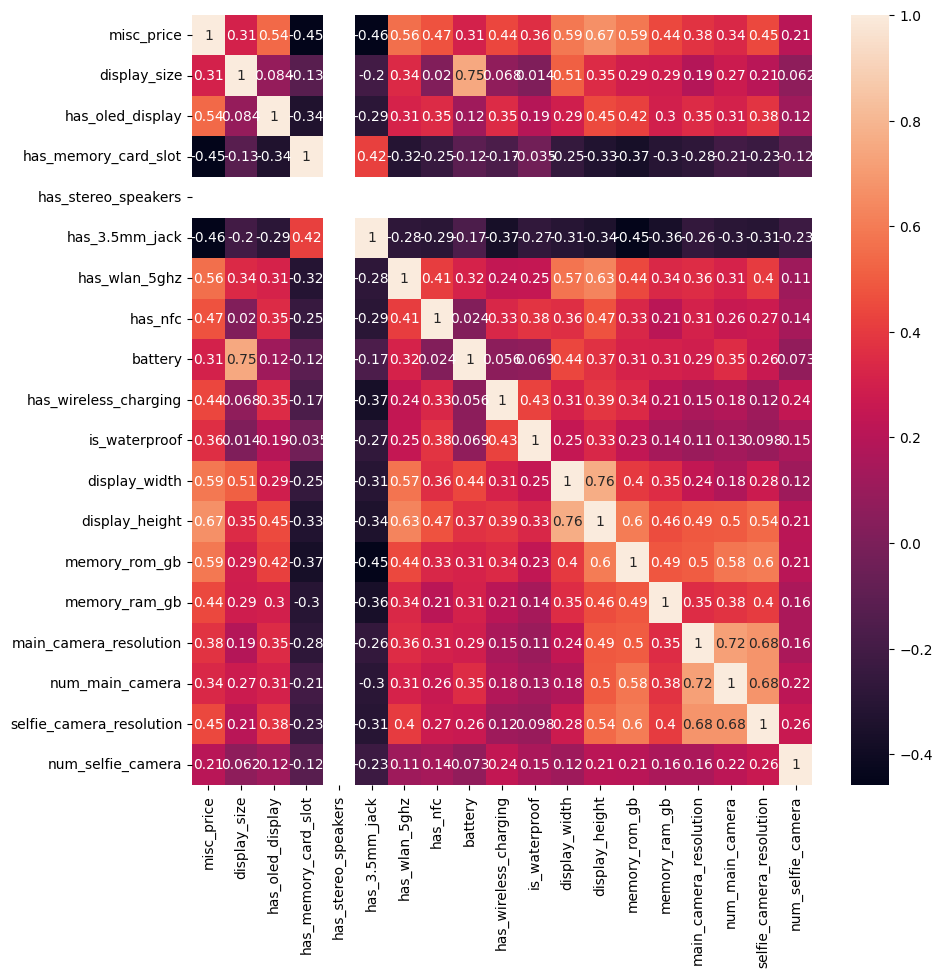

In [47]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [579]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["misc_price"]), df.misc_price, test_size=0.15, random_state=42)

In [580]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (1593, 18), X_test: (282, 18), y_train: (1593,), y_test: (282,)


In [ ]:
# one-hot encoding of y_train and y_test
# onehot = OneHotEncoder(sparse_output=False)
# y_train = onehot.fit_transform(y_train.values.reshape(-1, 1))
# y_test = onehot.transform(y_test.values.reshape(-1, 1))

In [581]:
# split train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}")

X_train: (1274, 18), X_val: (319, 18), y_train: (1274,), y_val: (319,)


## XGBOOST MODEL AND TRAINING

TODO:
- try [feature interaction constraints](https://xgboost.readthedocs.io/en/stable/tutorials/feature_interaction_constraint.html) (it allows to specify which features can interact.
- if you increase "min_child_weight" a lot (>40), the test accuracy decreases less than the training accuracy (but we are ruining the training accuracy).

In [132]:
xgboost_params = {"objective":"multi:softmax", "num_class":len(labels), "random_state":42,
                  "eval_metric":["merror", "mlogloss"], "early_stopping_rounds":20,
                  "gamma": 1, "learning_rate": 0.001, "n_estimators":500, "colsample_bytree": 0.6}

In [133]:
xgb_model = xgb.XGBClassifier()
xgb_model.set_params(**xgboost_params)

# We pass the .to_numpy() version to avoid error on onnx conversion
xgb_model.fit(X_train.to_numpy(), y_train.to_numpy(), eval_set=[(X_train.to_numpy(), y_train.to_numpy()),(X_val.to_numpy(), y_val.to_numpy())], verbose=False);

In [134]:
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)
print(f"Accuracy on the training set: {accuracy_score(y_train, y_pred_train)*100:.2f} %")
print(f"Accuracy on the test set: {accuracy_score(y_test, y_pred_test)*100:.2f} %")

Accuracy on the training set: 73.70 %
Accuracy on the test set: 70.21 %


Let's examine the difference between training and test set.

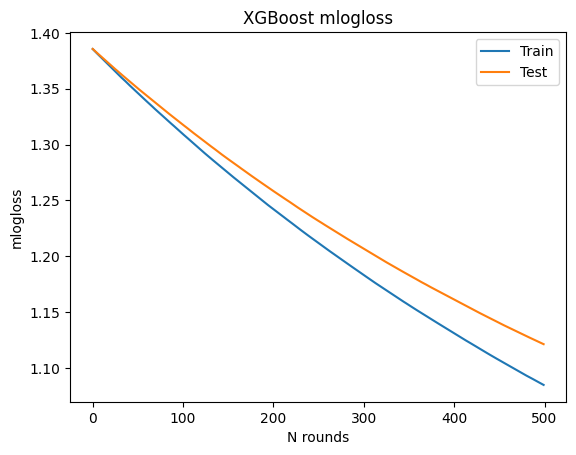

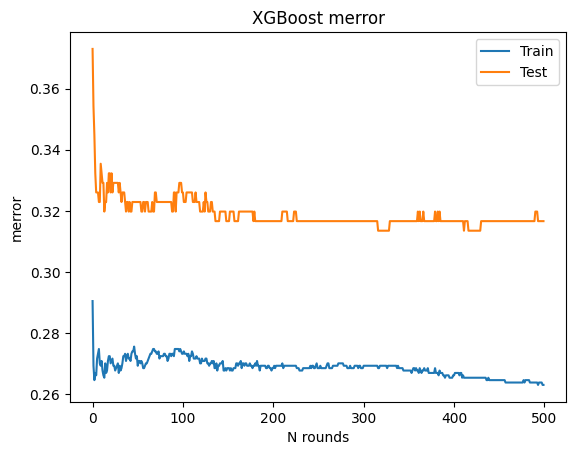

In [135]:
def plot_train_val_errors(results, metrics: list):
    # Retrieve performance metrics
    epochs = len(results['validation_0'][metrics[0]])
    x_axis = range(0, epochs)

    for met in metrics:
        # Plot log loss
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['validation_0'][met], label='Train')
        ax.plot(x_axis, results['validation_1'][met], label='Test')
        ax.legend()
        plt.ylabel(f'{met}')
        plt.xlabel("N rounds")
        plt.title(f'XGBoost {met}')
        plt.show()

plot_train_val_errors(xgb_model.evals_result(), ['mlogloss', 'merror'])

We can also plot an "importance" score for each feature computed by the model.

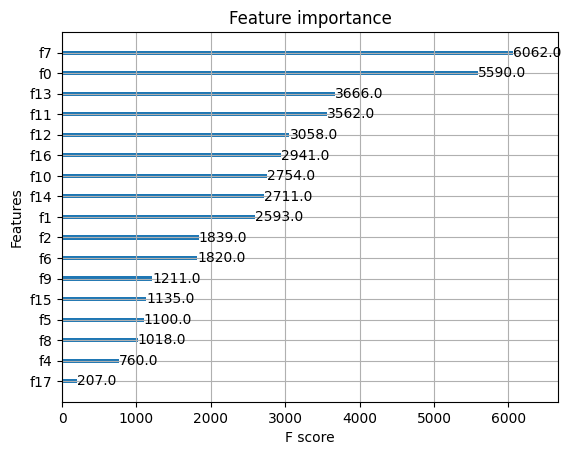

<Figure size 1600x1000 with 0 Axes>

In [136]:
xgb.plot_importance(xgb_model)
plt.figure(figsize = (16, 10))
plt.show()

### Grid search on some hyperparameters
We want to find the best set of parameters for the model therefore we are going to perform a grid search.

In [ ]:
param_grid = {
    "max_depth": np.arange(3,11),
    "learning_rate": np.linspace(0.001, 0.3, num=7, retstep=False),
    "n_estimators": np.arange(100, 501, step=100),
    "gamma": [0, 1, 2],
    "colsample_bytree": [0.6, 0.8],
}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="multi:softmax", num_class=len(labels), random_state=42,
                           eval_metric=["merror", "mlogloss"], early_stopping_rounds=20)

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, scoring="balanced_accuracy")

# Fit
_ = grid_cv.fit(X_train, y_train, eval_set=[(X_val, y_val)])

In [ ]:
grid_cv.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.20033333333333334,
 'max_depth': 9,
 'n_estimators': 100}

Now we try to create and train a model with the best parameters chosen by the grid search in order to check the accuracy on the training and test sets.

In [ ]:
par = {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 9, 
       'n_estimators':100, 'early_stopping_rounds':20, 'eval_metric':["merror", "mlogloss"]}

xgb_cv = xgb.XGBClassifier(objective="multi:softmax", num_class=len(labels), random_state=42)
xgb_cv.set_params(**par)
xgb_cv.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=4, num_parallel_tree=None, objective='multi:softmax', ...)

In [ ]:
y_pred_train = xgb_cv.predict(X_train)
y_pred_test = xgb_cv.predict(X_test)
print(f"Accuracy on the training set: {accuracy_score(y_train, y_pred_train)*100:.2f} %")
print(f"Accuracy on the test set: {accuracy_score(y_test, y_pred_test)*100:.2f} %")

Accuracy on the training set: 90.74 %
Accuracy on the test set: 67.24 %


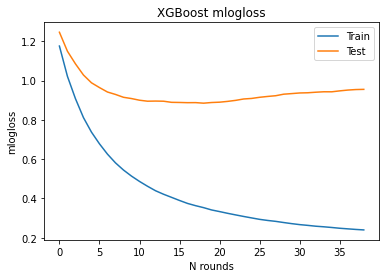

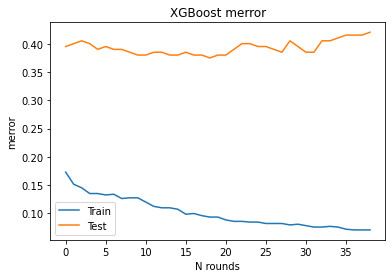

In [ ]:
plot_train_val_errors(xgb_cv.evals_result(), ['mlogloss', 'merror'])

As you can see the accuracy on the training set is higher but at the same time there is a lot of overfitting and on the test set we don't get an accuracy as good as before.

## LightGBM model

One of the main drawbacks of this model is that it can overfit with small datasets.

In [138]:
!pip install -q lightgbm

import lightgbm as lgb

In [582]:
lgb_params = {"learning_rate": 0.05, "num_iterations":1000, "early_stopping_round":50, 
              "max_bin": 30, "num_leaves": 30, "lambda_l1": 0.3}

In [583]:
lgb_model = lgb.LGBMClassifier(random_state=42, force_row_wise=True, verbosity=0)
lgb_model.set_params(**lgb_params)

lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val),(X_train,y_train)],
              eval_metric=['multi_error','multi_logloss']);

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's multi_error: 0.407378	training's multi_logloss: 1.2129	valid_0's multi_error: 0.416928	valid_0's multi_logloss: 1.21741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's multi_error: 0.412873	training's multi_logloss: 1.16352	valid_0's multi_error: 0.416928	val

In [584]:
print(f"The model has an accuracy of {lgb_model.score(X_train, y_train)*100:.2f}% on the training set.")
print(f"The model has an accuracy of {lgb_model.score(X_test, y_test)*100:.2f}% on the test set.")

The model has an accuracy of 77.00% on the training set.
The model has an accuracy of 71.63% on the test set.


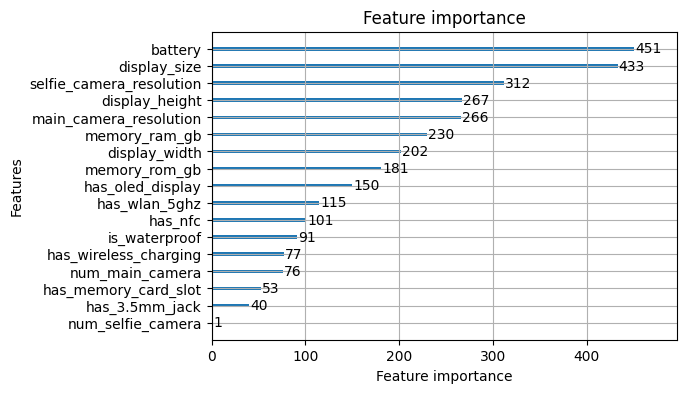

In [421]:
lgb.plot_importance(lgb_model, figsize=(6,4));

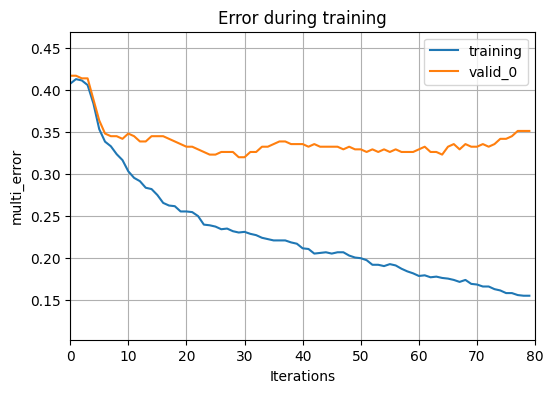

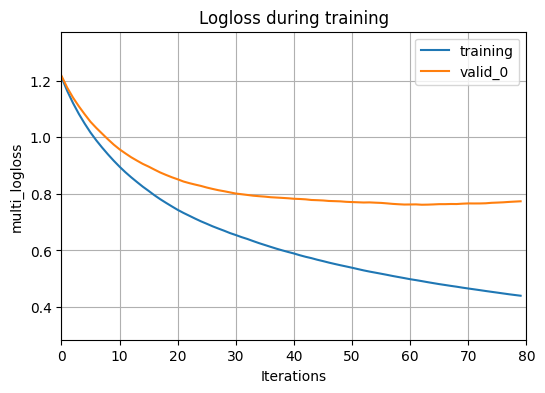

In [423]:
lgb.plot_metric(lgb_model, metric="multi_error", title="Error during training", figsize=(6,4));
lgb.plot_metric(lgb_model, metric="multi_logloss", title="Logloss during training", figsize=(6,4));

<Axes: >

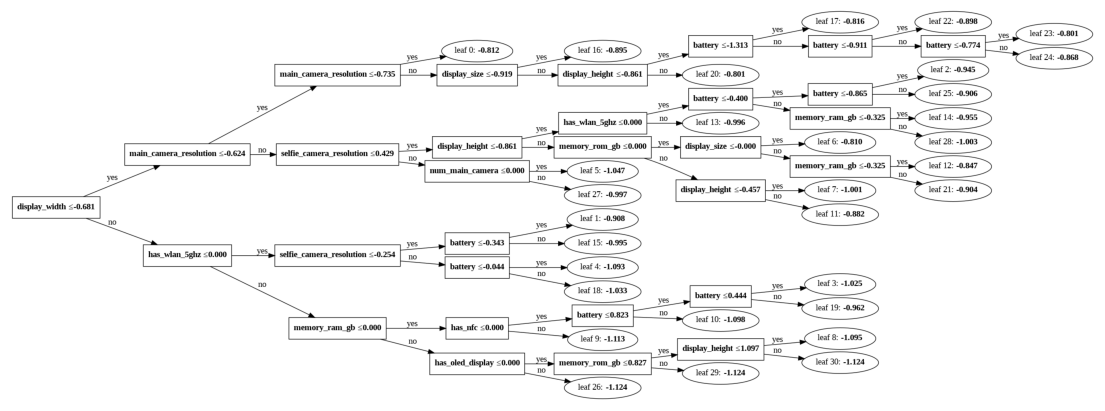

In [199]:
lgb.plot_tree(lgb_model, figsize=(14, 8));

## Counterfactual explanation

We have found two different libraries that allow to perform counterfactual explanation, the first one is OMLT and the second one is DICE.

### OMLT (WIP)

In [612]:
import tempfile

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt.neuralnet import FullSpaceNNFormulation
from omlt.io.onnx import write_onnx_model_with_bounds
from omlt.gbt import GBTBigMFormulation, GradientBoostedTreeModel
from omlt.block import OmltBlock

import onnx

In [613]:
x_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

In [ ]:
idx = 3
sample_idx = x_test_np[idx]
label_idx = y_test_np[idx]

#define dummy input tensor    
x_dummy = x_test_np[idx].reshape((1, x_test_np.shape[1]))

# Define input region defined by infinity norm
epsilon_infty = 5e-1
lb = np.repeat(-1, len(sample_idx))
# lb = np.maximum(-1, sample_idx - epsilon_infty)
ub = np.repeat(1, len(sample_idx))
# ub = np.minimum(1, sample_idx + epsilon_infty)

#save input bounds as dictionary
input_bounds = {}
for i in range(x_test_np.shape[1]):
    input_bounds[i] = (float(lb[i]), float(ub[i])) 

At this point we need to save the xgboost classifier in a onnx model to work with omlt. 

In [ ]:
!pip install -q onnxmltools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 8.7 MB/s eta 0:00:00


In [ ]:
from onnxmltools import convert_xgboost
from onnxmltools.utils import save_model
import json
from skl2onnx.common.data_types import FloatTensorType

import onnx

We convert the xgboost model to a onnx model and we can also save it in a file.

In [ ]:
def get_onnx_model(model, n_feature, save=True):
    # export onnx model
    float_tensor_type = FloatTensorType([None, n_feature])
    initial_types = [('float_input', float_tensor_type)]
    nodes_hitrates = OmltBlock.initialize_nodes_hitrates()
    onnx_model = convert_xgboost(model, initial_types=initial_types,
                                 custom_conversion_functions={},
                                 nodes_hitrates=nodes_hitrates)
    # To fix error with omlt
    onnx_model.graph.output.pop(0)
    if save:
        save_model(onnx_model, './xgboost_model.onnx')     
    return onnx_model

onnx_model = get_onnx_model(xgb_model, x_test_np.shape[1], save=False)

AttributeError: ignored

In [ ]:
# TODO: if the previous function doesn't save the model in the correct way try this
# def write_onnx_to_file(onnx_model, file_name="omlt_xgboost.onnx"):
#     with open(file_name, "wb") as onnx_file:
#         onnx_file.write(onnx_model.SerializeToString())
#         print(f'Onnx model written to {onnx_file.name}')

# write_onnx_to_file(onnx_model)

We define the opt_model as a ConcreteModel() imported from Pyomo. By first initializing an OmltBlock(), we can add a formulation using the build_formulation function. For tree ensembles we use the GradientBoostedTreeModel object and a BigMFormulation imported from omlt.gbt. Here we provide the onnx_model and input bounds of the black-box function. The add_tree_model function captures all procedures and adds a tree model block to an existing Pyomo model. You can build the Pyomo model and print the formulation using pprint() to check if everything works correctly.

In [ ]:
def add_tree_model(opt_model, onnx_model, input_bounds):
    # init omlt block and gbt model based on the onnx format
    opt_model.gbt = OmltBlock()
    gbt_model = GradientBoostedTreeModel(onnx_model, 
                                         scaled_input_bounds=input_bounds)
    
    # omlt uses a big-m formulation to encode the tree models
    formulation = GBTBigMFormulation(gbt_model)
    opt_model.gbt.build_formulation(formulation)

opt_model = pyo.ConcreteModel()
add_tree_model(opt_model, onnx_model, input_bounds)

KeyError: ignored

In [ ]:
omlt_model = GradientBoostedTreeModel(onnx_model, scaled_input_bounds=input_bounds)

AssertionError: ignored

In [ ]:
#create pyomo model
m = pyo.ConcreteModel()

#create an OMLT block for the neural network and build its formulation
m.nn = OmltBlock()
m.nn.build_formulation(formulation) 

In [ ]:
m.display()

Model unknown

  Variables:
    None

  Objectives:
    None

  Constraints:
    None

  Blocks:
    Block nn
    
      Variables:
        inputs : Size=16, Index=nn.inputs_set
            Key : Lower : Value : Upper : Fixed : Stale : Domain
              0 :  -1.0 :     0 :   1.0 : False :  True :  Reals
              1 :  -1.0 :     0 :   1.0 : False :  True :  Reals
              2 :  -1.0 :     0 :   1.0 : False :  True :  Reals
              3 :  -1.0 :     0 :   1.0 : False :  True :  Reals
              4 :  -1.0 :     0 :   1.0 : False :  True :  Reals
              5 :  -1.0 :     0 :   1.0 : False :  True :  Reals
              6 :  -1.0 :     0 :   1.0 : False :  True :  Reals
              7 :  -1.0 :     0 :   1.0 : False :  True :  Reals
              8 :  -1.0 :     0 :   1.0 : False :  True :  Reals
              9 :  -1.0 :     0 :   1.0 : False :  True :  Reals
             10 :  -1.0 :     0 :   1.0 : False :  True :  Reals
             11 :  -1.0 :     0 :   1.0 : 

In [ ]:
#@title ### Download cplex from drive and install it
id_cplex_file = "1ePJy9nsNYfkvErFuedT6mbPmTfriQ2e8"
gdown.download(id=id_cplex_file, output="cplex_binary.bin", quiet=False)

# We can use /usr/bin/cplex as installation path when requested
!bash cplex_binary.bin

Define the objective expression to optimize.

ATTENTION: if you run twice the cell an error will be raised because we overwrite the block, hence you need to run again the cell in which we create the model before to apply changes.

In [ ]:
medians = np.median(X_train, axis=0)
distances_j = lambda j: [np.abs(X_train[i,j]-medians[j]) for i in range(len(X_train))]

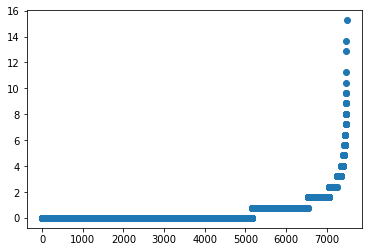

In [ ]:
plt.scatter(np.arange(len(distances_j(5))), np.sort(distances_j(5)))

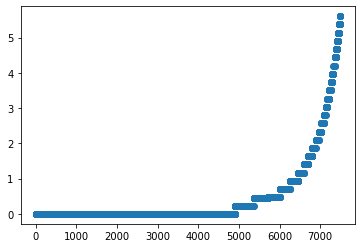

In [ ]:
plt.scatter(np.arange(len(distances_j(13))), np.sort(distances_j(13)))

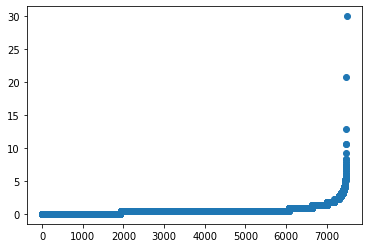

In [ ]:
plt.scatter(np.arange(len(distances_j(14))), np.sort(distances_j(14)))

In [ ]:
# Create an expression that is the difference between the numpy array and the indexed variable
medians = np.median(X_train, axis=0)
MAD = lambda j: np.median([(X_train[i,j]-medians[j])**2 for i in range(len(X_train))])+0.0001

diff_expr = sum(((sample_idx[i] - m.nn.inputs[i])**2)/MAD(i) for i in range(len(sample_idx)))

# Set the objective function to be the difference expression
# m.obj = pyo.Objective(expr=((m.nn.outputs[0] - 1e-3)**2))
m.obj = pyo.Objective(expr=((m.nn.outputs[0] - 1)**2 + diff_expr))

Check what is the expression

In [ ]:
m.obj.expr.to_string()

'(-2.1237396965035487 - nn.inputs[0])**2/0.6516353444604 + (2.0720732888939324 - nn.inputs[1])**2/0.34623306121992614 + (-0.04351394719762343 - nn.inputs[2])**2/0.10124551965735235 + (1.7089763559995648 - nn.inputs[3])**2/0.3471737320369636 + (1.8339104173603789 - nn.inputs[4])**2/0.3803238127439624 + (3.549286259709461 - nn.inputs[5])**2/0.0001 + (-1.5579603212136566 - nn.inputs[6])**2/0.06504566196263667 + (-0.5031576652363163 - nn.inputs[7])**2/0.0030953442295281477 + (-1.0488330153245893 - nn.inputs[8])**2/0.36107624481471046 + (-1.2815928873154365 - nn.inputs[9])**2/1.1664687776793121 + (2.075747003769893 - nn.inputs[10])**2/0.37118085351501906 + (-0.47375867541069705 - nn.inputs[11])**2/0.2980712520692345 + (0.4193474489240483 - nn.inputs[12])**2/0.45131853211456807 + (0.0029525990677453434 - nn.inputs[13])**2/0.0001 + (0.7170676851210651 - nn.inputs[14])**2/0.21347155762320297 + (-0.4840680843240054 - nn.inputs[15])**2/0.6532802264991835 + (nn.outputs[0] - 1)**2'

Install a solver to optimize the problem.

In [ ]:
!apt-get install -y -qq coinor-cbc

^C


In [ ]:
#pyo_solution = pyo.SolverFactory('cbc', executable='/usr/bin/cbc').solve(m, tee=True)
pyo_solution = pyo.SolverFactory('cplex', executable='/usr/bin/cplex/cplex/bin/x86-64_linux/cplex').solve(m, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile '/tmp/tmp7r862w9a.cplex.log' open.
CPLEX> Problem '/tmp/tmp0r3e1jli.pyomo.lp' read.
Read time = 0.01 sec. (0.13 ticks)
CPLEX> Problem name         : /tmp/tmp0r3e1jli.pyomo.lp
Objective sense      : Minimize
Variables            :     437  [Nneg: 1,  Box: 306,  Free: 2,  Binary: 128,
                                 Qobj: 17]
Objective nonzeros   :      18
Objective Q nonzeros :      17
Linear constraints   :     677  [Less: 384,  Greater: 128,  Equal: 165]
  Nonzeros           :    6408
  RHS nonzeros       :     258

Variables            : Min LB: -53.65274        Max UB: 31.27704       
Objec

In [ ]:
# will show you the evaluation of the OBJ function
m.obj.display()
# will print the evaluation of the OBJ function, and give direct access to the value
print(m.obj.expr())   

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 65009.41689532917
65009.41689532917


Extract the values of the found sample and test if it actually leads to the desired label.

In [ ]:
def evaluate_sample(data_loader):
    y_pred_list = []
    model.eval()
    with torch.no_grad():
        for X_batch in data_loader:
            X_batch = X_batch.to(device)
            # inference
            y_pred = model(X_batch)
            y_pred_list.append(y_pred.cpu().numpy())

    y_pred_list = [y[0] for ys in y_pred_list for y in ys]
    return y_pred_list

eval_test = evaluate_sample(test_loader)

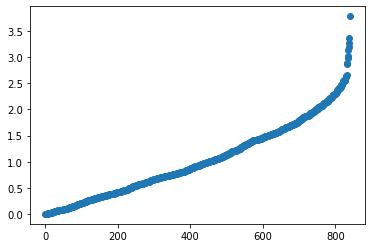

In [ ]:
positive_test = [x for x in eval_test if x > 0]

plt.scatter(np.arange(len(positive_test)), np.sort(positive_test))
print("Median: " + np.median(positive_test))

In [ ]:
count_sample_dict = list(m.nn.inputs.get_values().values())

test_fin = torch.tensor([count_sample_dict])

In [ ]:
model.eval()

with torch.no_grad():
    test_fin = test_fin.to(device)
    y_test_pred = model(test_fin)
    print(y_test_pred)
    y_test_pred = torch.sigmoid(y_test_pred)
    print(y_test_pred)
    y_pred_tag = torch.round(y_test_pred)

print("The sample has now {} as label".format(y_pred_tag))

tensor([[0.1062]])
tensor([[0.5265]])
The sample has now tensor([[1.]]) as label


### Dice

In [410]:
!pip install -q dice-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.0 MB/s eta 0:00:00


In [411]:
import dice_ml

We concatenate the X with the labels because Dice expects a unique dataframe and then you specify which column is the target one.

In [585]:
df_dice = pd.concat([X_train, y_train], axis=1)

In [418]:
df_dice.head()

,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,battery,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera,misc_price
1806,-0.332716,0.0,0.0,0.0,1.0,1.0,1.0,-0.231339,0.0,0.0,0.417097,0.280884,0.229811,0.751185,-0.269380,-0.631152,0.907021,-0.220643,1.0
1104,-0.609667,0.0,0.0,0.0,1.0,1.0,1.0,-0.687547,0.0,0.0,0.417097,0.280884,-0.665519,-0.478653,-0.319564,-0.631152,-0.594922,-0.220643,1.0
1573,-0.148082,0.0,1.0,0.0,0.0,1.0,1.0,-0.249587,1.0,1.0,0.417097,0.727832,0.229811,0.136266,0.160769,-0.631152,-0.594922,-0.220643,3.0
1632,0.405821,0.0,1.0,0.0,1.0,1.0,0.0,-0.126411,0.0,0.0,0.417097,0.951305,1.423585,0.751185,-0.054306,0.447617,1.999343,-0.220643,2.0
1697,-0.332716,0.0,1.0,0.0,1.0,0.0,0.0,-0.413822,0.0,0.0,0.417097,0.280884,-0.665519,-0.478653,-0.269380,-0.631152,-0.594922,-0.220643,0.0


In [586]:
cont_features = ['display_size', 'battery', 'display_width', 'display_height', 'memory_rom_gb',
                 'memory_ram_gb', 'main_camera_resolution', 'num_main_camera', 'selfie_camera_resolution',
                 'num_selfie_camera']
# Dataset for training an ML model
d = dice_ml.Data(dataframe=df_dice,
                 continuous_features=df_dice.columns[:-1].tolist(),
                 outcome_name='misc_price')

# Pre-trained ML model
# TODO: change backend="sklearn" if DT used
m = dice_ml.Model(model=lgb_model,
                  backend='sklearn')

# DiCE explanation instance
# TODO: put method="genetic" if DT used
exp = dice_ml.Dice(d, m, method="genetic")

In [606]:
idx = 40
count_class = 2

orig_sample = X_train.iloc[[idx]]
orig_sample_lab = y_train.iloc[idx]

e1 = exp.generate_counterfactuals(orig_sample, total_CFs=1, desired_class=count_class)
e1.visualize_as_dataframe(show_only_changes=False)

100%|██████████| 1/1 [00:03<00:00,  3.78s/it]

Query instance (original outcome : 3)


,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,battery,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera,misc_price
0,0.535065,1.0,0.0,0.0,1.0,1.0,1.0,0.81794,0.0,0.0,0.417097,1.174779,1.423585,1.366104,3.386887,2.605155,3.091665,-0.220643,3.0



Diverse Counterfactual set (new outcome: 2)


,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,battery,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera,misc_price
0,0.535065,1.0,0.0,0.0,1.0,1.0,1.0,0.863561,0.0,0.0,0.417097,1.174779,1.423585,0.751185,2.239823,2.605154,0.907021,-0.220643,2


In [608]:
count_sample = np.array([0.535065, 1, 0, 0, 1, 1, 1, 0.863561, 0, 0, 0.417097, 1.174779, 1.423585, 0.751185, 2.239823, 2.605154, 0.907021, -0.220643])

In [609]:
def get_values_from_scaled(scaler_num, features, count_sample, orig_sample):
    new_values = []
    old_values = []
    for feat, c_val, o_val in zip(features, count_sample, orig_sample):
        if feat in scaler_num:
            new = scaler_num[feat].inverse_transform(np.reshape(c_val, (1, 1)))[0]
            old = scaler_num[feat].inverse_transform(np.reshape(o_val, (1, 1)))[0]
            new_values.append(new[0])
            old_values.append(old[0])
        else:
            new_values.append(c_val)
            old_values.append(o_val)
    return new_values, old_values

In [610]:
new_val, old_val = get_values_from_scaled(scaler_num, X_train.columns, count_sample, orig_sample.to_numpy()[0])

In [611]:
comp_df = pd.DataFrame(list(zip(old_val, new_val)), index=X_train.columns, columns=['Original_sample','Counterfactual'])
# Add labels
comp_df.loc['misc_price'] = [orig_sample_lab, count_class]
comp_df

,Original_sample,Counterfactual
display_size,6.44,6.440000
has_oled_display,1.00,1.000000
has_memory_card_slot,0.00,0.000000
has_stereo_speakers,0.00,0.000000
has_3.5mm_jack,1.00,1.000000
has_wlan_5ghz,1.00,1.000000
has_nfc,1.00,1.000000
battery,4350.00,4400.000406
has_wireless_charging,0.00,0.000000
is_waterproof,0.00,0.000000
